<a href="https://colab.research.google.com/github/pzangra/Progetto-Icu/blob/main/xgboost_on_mimiciv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

XGBOOST model moduled for rdsf_data.csv

In [131]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
!pip install -U xgboost
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#### Importing the data
##### Loading the dataset from the IBM Base Samples. The dataset in use is the Telco Churn Dataset.

In [133]:
#read data
adf = pd.read_csv('/content/drive/MyDrive/dataset/rdsf_data.csv')

Reformat gender, insurance, language objects to numbers

In [134]:
# Ensure consistent casing in the insurance column
if 'insurance' in adf.columns:
    adf['insurance'] = adf['insurance'].astype(str).str.lower()  # Convert all values to strings and lowercase
    adf['insurance'] = adf['insurance'].replace({'medicare': 3, 'medicaid': 2, 'other': 1})
    adf['insurance'] = pd.to_numeric(adf['insurance'], errors='coerce')  # Convert to numeric, setting invalid values to NaN
    adf['insurance'] = adf['insurance'].fillna(0).astype(int)  # Fill NaNs with a default value and convert to integer

# Ensure gender column is properly mapped and converted
if 'gender' in adf.columns:
    adf['gender'] = adf['gender'].astype(str).str.lower()  # Convert all values to strings and lowercase
    adf['gender'] = adf['gender'].replace({'m': 2, 'f': 1})
    adf['gender'] = pd.to_numeric(adf['gender'], errors='coerce')  # Convert to numeric, setting invalid values to NaN
    adf['gender'] = adf['gender'].fillna(0).astype(int)  # Fill NaNs with a default value and convert to integer

# Ensure language column is properly mapped and converted
if 'language' in adf.columns:
    adf['language'] = adf['language'].astype(str).str.lower()  # Convert all values to strings and lowercase
    adf['language'] = adf['language'].replace({'english': 2, '?': 1, 'n/a': 0})
    adf['language'] = pd.to_numeric(adf['language'], errors='coerce')  # Convert to numeric, setting invalid values to NaN
    adf['language'] = adf['language'].fillna(0).astype(int)  # Fill NaNs with a default value and convert to integer

# Ensure race column is properly mapped and grouped
if 'race' in adf.columns:
    # Convert all values to strings and lowercase for consistency
    adf['race'] = adf['race'].astype(str).str.lower()

    # Define race groups
    race_group_mapping = {
        # White group
        'white': 1, 'white - brazilian': 1, 'white - eastern european': 1,
        'white - other european': 1, 'white - russian': 1,

        # Asian group
        'asian': 2, 'asian - asian indian': 2, 'asian - chinese': 2,
        'asian - korean': 2, 'asian - south east asian': 2,

        # Black group
        'black/african': 3, 'black/african american': 3, 'black/cape verdean': 3,
        'black/caribbean island': 3,

        # Latino group
        'hispanic or latino': 4, 'hispanic/latino - central american': 4,
        'hispanic/latino - columbian': 4, 'hispanic/latino - cuban': 4,
        'hispanic/latino - dominican': 4, 'hispanic/latino - guatemalan': 4,
        'hispanic/latino - honduran': 4, 'hispanic/latino - mexican': 4,
        'hispanic/latino - puerto rican': 4, 'hispanic/latino - salvadoran': 4,
        'south american': 4, 'portuguese': 4,

        # Islander group
        'native hawaiian or other pacific islander': 5,

        # Native group
        'american indian/alaska native': 6,

        # Other group
        'multiple race/ethnicity': 7, 'other': 7,

        # Unspecified or Declined
        'patient declined to answer': 0, 'unable to obtain': 0, 'unknown': 0, 'n/a': 0
    }

    # Apply mapping
    adf['race'] = adf['race'].replace(race_group_mapping)

    # Convert to numeric, handling any unexpected values as NaN
    adf['race'] = pd.to_numeric(adf['race'], errors='coerce')

    # Fill NaN values with 0 and convert to integer type
    adf['race'] = adf['race'].fillna(0).astype(int)

# Ensure sepsis3 column is properly mapped to binary values
if 'sepsis3' in adf.columns:
    # Convert the column: True -> 1, missing/NaN -> 0
    adf['sepsis3'] = adf['sepsis3'].notna().astype(int)

<ipython-input-134-6b42cd451f29>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adf['insurance'] = adf['insurance'].replace({'medicare': 3, 'medicaid': 2, 'other': 1})
<ipython-input-134-6b42cd451f29>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adf['gender'] = adf['gender'].replace({'m': 2, 'f': 1})
<ipython-input-134-6b42cd451f29>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt

##### Looking at the first five rows

In [135]:
adf.head()

,subject_id,stay_id,antibiotic_time,culture_time,suspected_infection_time,sofa_time,sofa_score,respiration,coagulation,liver,...,avg_bicarbonate,avg_ph,avg_so2,avg_po2,avg_pco2,avg_aado2,avg_aado2_calc,avg_pao2fio2ratio,avg_baseexcess,avg_totalco2
0,10018862,37957444,07/06/2149 19:00,06/06/2149 21:49,06/06/2149 21:49,07/06/2149 19:00,5.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10039708,33281088,23/01/2140 20:00,23/01/2140 13:40,23/01/2140 13:40,23/01/2140 20:00,6.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,37.45,NaN,94.0,NaN
2,10040025,36107367,25/01/2148 20:00,23/01/2148 12:15,23/01/2148 12:15,24/01/2148 05:00,4.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10047172,34369439,15/06/2163 04:00,14/06/2163 21:46,14/06/2163 21:46,15/06/2163 04:00,4.0,0.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10054277,38035170,01/07/2126 08:00,29/06/2126 23:57,29/06/2126 23:57,30/06/2126 00:00,2.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
# Check the size of the dataframe
print(f"Shape :{adf.shape}")
# Check the columns
print(f"Columns: {adf.columns}")

Shape :(23090, 67)
Columns: Index(['subject_id', 'stay_id', 'antibiotic_time', 'culture_time',
       'suspected_infection_time', 'sofa_time', 'sofa_score', 'respiration',
       'coagulation', 'liver', 'cardiovascular', 'cns', 'renal', 'sepsis3',
       'rn', 'intime', 'outtime', 'icu_hours', 'dod', 'st48h', 'st90d',
       'stinhosp', 'age', 'weight', 'gender', 'language', 'insurance', 'race',
       'gcs', 'avg_heart_rate', 'avg_sbp', 'avg_dbp', 'avg_pressure',
       'avg_body_temperature', 'avg_spo2', 'avg_resp_rate', 'fio2', 'avg_icp',
       'albumin', 'globulin', 'total_protein', 'aniongap',
       'avg_bicarbonate_chem', 'bun', 'avg_calcium_chem', 'avg_chloride_chem',
       'creatinine', 'avg_glucose_chem', 'avg_sodium_chem',
       'avg_potassium_chem', 'avg_magnesium', 'ionised_ca', 'mpv', 'pt', 'ptt',
       'inr', 'avg_lactate', 'avg_bicarbonate', 'avg_ph', 'avg_so2', 'avg_po2',
       'avg_pco2', 'avg_aado2', 'avg_aado2_calc', 'avg_pao2fio2ratio',
       'avg_baseexcess'

In [137]:
adf.head()

,subject_id,stay_id,antibiotic_time,culture_time,suspected_infection_time,sofa_time,sofa_score,respiration,coagulation,liver,...,avg_bicarbonate,avg_ph,avg_so2,avg_po2,avg_pco2,avg_aado2,avg_aado2_calc,avg_pao2fio2ratio,avg_baseexcess,avg_totalco2
0,10018862,37957444,07/06/2149 19:00,06/06/2149 21:49,06/06/2149 21:49,07/06/2149 19:00,5.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10039708,33281088,23/01/2140 20:00,23/01/2140 13:40,23/01/2140 13:40,23/01/2140 20:00,6.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,37.45,NaN,94.0,NaN
2,10040025,36107367,25/01/2148 20:00,23/01/2148 12:15,23/01/2148 12:15,24/01/2148 05:00,4.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10047172,34369439,15/06/2163 04:00,14/06/2163 21:46,14/06/2163 21:46,15/06/2163 04:00,4.0,0.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10054277,38035170,01/07/2126 08:00,29/06/2126 23:57,29/06/2126 23:57,30/06/2126 00:00,2.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### We need to drop the following columns since they are irrelevant and should not be used for prediction

In [138]:
adf.drop(['subject_id', 'stay_id', 'antibiotic_time', 'culture_time',
       'suspected_infection_time', 'sofa_time', 'rn','intime', 'outtime',
       'language', 'insurance', 'race',
       'dod', 'ionised_ca', 'mpv', 'pt', 'ptt',
       'inr', 'avg_lactate', 'avg_bicarbonate', 'avg_ph', 'avg_so2', 'avg_po2',
       'avg_pco2', 'avg_aado2', 'avg_aado2_calc', 'avg_pao2fio2ratio'],axis=1,inplace=True)

In [139]:
adf.head()

,sofa_score,respiration,coagulation,liver,cardiovascular,cns,renal,sepsis3,icu_hours,st48h,...,bun,avg_calcium_chem,avg_chloride_chem,creatinine,avg_glucose_chem,avg_sodium_chem,avg_potassium_chem,avg_magnesium,avg_baseexcess,avg_totalco2
0,5.0,0.0,2.0,0.0,3.0,0.0,0.0,1,26,1,...,5.33,7.90,108.0,0.63,155.67,143.00,4.03,1.75,NaN,NaN
1,6.0,0.0,0.0,0.0,4.0,0.0,2.0,1,388,1,...,39.40,7.00,116.2,1.94,232.40,140.60,3.28,2.02,94.0,NaN
2,4.0,0.0,0.0,0.0,1.0,1.0,2.0,1,157,1,...,58.20,8.30,97.0,1.98,203.80,135.60,4.34,1.85,NaN,NaN
3,4.0,0.0,0.0,2.0,0.0,1.0,1.0,1,44,1,...,41.80,6.87,102.6,1.26,244.60,136.80,3.90,1.93,NaN,NaN
4,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1,63,1,...,17.33,8.97,102.0,0.50,106.67,138.67,4.10,2.20,NaN,NaN


### Identifying missing data.
#### XGBoost has default behavior for missing data.

In [140]:
adf.dtypes

,0
sofa_score,float64
respiration,float64
coagulation,float64
liver,float64
cardiovascular,float64
cns,float64
renal,float64
sepsis3,int64
icu_hours,int64
st48h,int64


In [141]:
adf['st48h'].unique()
adf['st90d'].unique()
adf['stinhosp'].unique()

array([1, 0])

#### Handling Missing Data

#### XGBoost only allows ints, floats and boolean data types

In [142]:
def process_missing_values(adf):
    for column in adf.columns:
        # Handle numeric columns
        if pd.api.types.is_numeric_dtype(adf[column]):
            # Fill NaN values with the rounded mean
            column_mean = round(adf[column].mean(), 2)
            adf[column] = adf[column].fillna(column_mean)
            print(f"Replaced missing values in numeric column '{column}' with the rounded mean: {column_mean}")

        else:
            # Handle non-numeric columns
            if adf[column].dtype == 'object':
                # Convert empty strings or non-values to NaN
                adf[column] = adf[column].replace(['', ' '], pd.NA)

                # Convert to lowercase strings for consistency
                adf[column] = adf[column].str.lower()

                # Fill NaN with the most frequent value (mode)
                column_mode = adf[column].mode(dropna=True)
                if not column_mode.empty:
                    mode_value = column_mode[0]
                    adf[column] = adf[column].fillna(mode_value)
                    print(f"Replaced missing values in categorical column '{column}' with the mode: {mode_value}")
                else:
                    print(f"No valid mode found for column '{column}'. Skipped.")

    return adf

In [143]:
adf = process_missing_values(adf)

Replaced missing values in numeric column 'sofa_score' with the rounded mean: 3.64
Replaced missing values in numeric column 'respiration' with the rounded mean: 0.66
Replaced missing values in numeric column 'coagulation' with the rounded mean: 0.49
Replaced missing values in numeric column 'liver' with the rounded mean: 0.27
Replaced missing values in numeric column 'cardiovascular' with the rounded mean: 1.14
Replaced missing values in numeric column 'cns' with the rounded mean: 0.47
Replaced missing values in numeric column 'renal' with the rounded mean: 0.6
Replaced missing values in numeric column 'sepsis3' with the rounded mean: 1.0
Replaced missing values in numeric column 'icu_hours' with the rounded mean: 132.59
Replaced missing values in numeric column 'st48h' with the rounded mean: 0.96
Replaced missing values in numeric column 'st90d' with the rounded mean: 0.73
Replaced missing values in numeric column 'stinhosp' with the rounded mean: 0.58
Replaced missing values in nume

 Splitting the data into two parts
1. The columns of data that we will use to make classifications
2. The column of data that we want to predict

In [144]:
#check dataframe
# Check the size of the dataframe
def adfinfo(adf):
    print(f"Shape :{adf.shape}")
    # Check the columns
    print(f"Columns: {adf.columns}")
    # Check the data types
    print(f"Data types: {adf.dtypes}")
    # Check for missing values
    print(f"Missing values: {adf.isna().sum()}")
adfinfo(adf)

Shape :(23090, 40)
Columns: Index(['sofa_score', 'respiration', 'coagulation', 'liver', 'cardiovascular',
       'cns', 'renal', 'sepsis3', 'icu_hours', 'st48h', 'st90d', 'stinhosp',
       'age', 'weight', 'gender', 'gcs', 'avg_heart_rate', 'avg_sbp',
       'avg_dbp', 'avg_pressure', 'avg_body_temperature', 'avg_spo2',
       'avg_resp_rate', 'fio2', 'avg_icp', 'albumin', 'globulin',
       'total_protein', 'aniongap', 'avg_bicarbonate_chem', 'bun',
       'avg_calcium_chem', 'avg_chloride_chem', 'creatinine',
       'avg_glucose_chem', 'avg_sodium_chem', 'avg_potassium_chem',
       'avg_magnesium', 'avg_baseexcess', 'avg_totalco2'],
      dtype='object')
Data types: sofa_score              float64
respiration             float64
coagulation             float64
liver                   float64
cardiovascular          float64
cns                     float64
renal                   float64
sepsis3                   int64
icu_hours                 int64
st48h                     int64
s

In [145]:
# columns of data used to make predictions
#remove st90d and stinhosp
X = adf.drop(['st48h', 'st90d', 'stinhosp'],axis=1)
X.head()

,sofa_score,respiration,coagulation,liver,cardiovascular,cns,renal,sepsis3,icu_hours,age,...,bun,avg_calcium_chem,avg_chloride_chem,creatinine,avg_glucose_chem,avg_sodium_chem,avg_potassium_chem,avg_magnesium,avg_baseexcess,avg_totalco2
0,5.0,0.0,2.0,0.0,3.0,0.0,0.0,1,26,57,...,5.33,7.90,108.0,0.63,155.67,143.00,4.03,1.75,86.65,78.59
1,6.0,0.0,0.0,0.0,4.0,0.0,2.0,1,388,48,...,39.40,7.00,116.2,1.94,232.40,140.60,3.28,2.02,94.00,78.59
2,4.0,0.0,0.0,0.0,1.0,1.0,2.0,1,157,69,...,58.20,8.30,97.0,1.98,203.80,135.60,4.34,1.85,86.65,78.59
3,4.0,0.0,0.0,2.0,0.0,1.0,1.0,1,44,74,...,41.80,6.87,102.6,1.26,244.60,136.80,3.90,1.93,86.65,78.59
4,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1,63,57,...,17.33,8.97,102.0,0.50,106.67,138.67,4.10,2.20,86.65,78.59


In [146]:
# column of data to predict.
y = adf['st48h']
y.head()

,st48h
0,1
1,1
2,1
3,1
4,1


### Format the Data Part 2: One-Hot encoding
It is the process of converting categorical data into multiple columns of binary values
They assign numbers to categories. Think of enumarating.  Either through Column Transformer of get_dummies

In [147]:
adfinfo(X)

Shape :(23090, 37)
Columns: Index(['sofa_score', 'respiration', 'coagulation', 'liver', 'cardiovascular',
       'cns', 'renal', 'sepsis3', 'icu_hours', 'age', 'weight', 'gender',
       'gcs', 'avg_heart_rate', 'avg_sbp', 'avg_dbp', 'avg_pressure',
       'avg_body_temperature', 'avg_spo2', 'avg_resp_rate', 'fio2', 'avg_icp',
       'albumin', 'globulin', 'total_protein', 'aniongap',
       'avg_bicarbonate_chem', 'bun', 'avg_calcium_chem', 'avg_chloride_chem',
       'creatinine', 'avg_glucose_chem', 'avg_sodium_chem',
       'avg_potassium_chem', 'avg_magnesium', 'avg_baseexcess',
       'avg_totalco2'],
      dtype='object')
Data types: sofa_score              float64
respiration             float64
coagulation             float64
liver                   float64
cardiovascular          float64
cns                     float64
renal                   float64
sepsis3                   int64
icu_hours                 int64
age                       int64
weight                  float64

In [148]:
X.dtypes

,0
sofa_score,float64
respiration,float64
coagulation,float64
liver,float64
cardiovascular,float64
cns,float64
renal,float64
sepsis3,int64
icu_hours,int64
age,int64


In [164]:
pd.get_dummies(X,columns=['gcs'], dtype='int').head()

,sofa_score,respiration,coagulation,liver,cardiovascular,cns,renal,sepsis3,icu_hours,age,...,gcs_7.0,gcs_8.0,gcs_9.0,gcs_10.0,gcs_11.0,gcs_12.0,gcs_13.0,gcs_13.19,gcs_14.0,gcs_15.0
0,5.0,0.0,2.0,0.0,3.0,0.0,0.0,1,26,57,...,0,0,0,0,0,0,0,0,0,1
1,6.0,0.0,0.0,0.0,4.0,0.0,2.0,1,388,48,...,0,0,0,0,0,0,0,0,1,0
2,4.0,0.0,0.0,0.0,1.0,1.0,2.0,1,157,69,...,0,0,0,0,0,0,1,0,0,0
3,4.0,0.0,0.0,2.0,0.0,1.0,1.0,1,44,74,...,0,0,0,0,0,0,0,0,1,0
4,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1,63,57,...,0,0,0,0,0,0,0,0,0,1


In [150]:
X_encoded = pd.get_dummies(X, columns=['sofa_score',
       'sepsis3', 'age', 'gender', 'gcs', 'icu_hours'], dtype='int')
X_encoded.tail(100)

,respiration,coagulation,liver,cardiovascular,cns,renal,weight,avg_heart_rate,avg_sbp,avg_dbp,...,icu_hours_1628,icu_hours_1783,icu_hours_1802,icu_hours_1855,icu_hours_1866,icu_hours_1898,icu_hours_2072,icu_hours_2185,icu_hours_2301,icu_hours_2391
22990,0.0,0.0,0.0,4.0,0.0,1.0,143.70,87.04,109.61,55.70,...,0,0,0,0,0,0,0,0,0,0
22991,0.0,2.0,0.0,3.0,0.0,0.0,65.77,77.62,108.67,57.79,...,0,0,0,0,0,0,0,0,0,0
22992,2.0,0.0,0.0,1.0,1.0,0.0,116.00,84.03,115.02,58.48,...,0,0,0,0,0,0,0,0,0,0
22993,2.0,1.0,0.0,1.0,0.0,0.0,83.43,72.03,102.87,51.40,...,0,0,0,0,0,0,0,0,0,0
22994,3.0,2.0,0.0,1.0,0.0,2.0,101.65,73.19,106.33,60.78,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23085,2.0,0.0,0.0,0.0,0.0,0.0,80.27,75.19,115.02,58.48,...,0,0,0,0,0,0,0,0,0,0
23086,0.0,0.0,0.0,1.0,1.0,0.0,68.50,87.71,115.02,58.48,...,0,0,0,0,0,0,0,0,0,0
23087,0.0,1.0,0.0,0.0,1.0,0.0,75.07,73.86,115.02,58.48,...,0,0,0,0,0,0,0,0,0,0
23088,3.0,2.0,0.0,0.0,0.0,0.0,73.80,84.62,134.76,59.11,...,0,0,0,0,0,0,0,0,0,0


In [151]:
y.unique()

array([1, 0])

#### Building a preliminary model
Now to split the data into training and testing sets to build the model

In [152]:
# This shows roughly the percentage of churned customers
sum(y)/len(y)

0.964356864443482

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y)

In [154]:
sum(y_train)/len(y_train)

0.9643702719870647

In [155]:
sum(y_test)/len(y_test)

0.9643166464576477

In [156]:
print(f"Training Size: {len(X_train)}")
print(f"Test Size: {len(X_test)}")
print(f'Training Set Shape: {X_train.shape}')

Training Size: 17317
Test Size: 5773
Training Set Shape: (17317, 1037)


In [157]:
print(f"Training Size: {len(y_train)}")
print(f"Test Size: {len(y_test)}")
print(f'Training Set Shape: {y_train.shape}')

Training Size: 17317
Test Size: 5773
Training Set Shape: (17317,)


#### The actual model
Binary logistic in xgb is for classification

In [158]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, eval_metric='aucpr')
clf_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-aucpr:0.98058
[1]	validation_0-aucpr:0.98665
[2]	validation_0-aucpr:0.98820
[3]	validation_0-aucpr:0.98944
[4]	validation_0-aucpr:0.98938
[5]	validation_0-aucpr:0.99231
[6]	validation_0-aucpr:0.99223
[7]	validation_0-aucpr:0.99230
[8]	validation_0-aucpr:0.99259
[9]	validation_0-aucpr:0.99281
[10]	validation_0-aucpr:0.99268
[11]	validation_0-aucpr:0.99287
[12]	validation_0-aucpr:0.99310
[13]	validation_0-aucpr:0.99317
[14]	validation_0-aucpr:0.99317
[15]	validation_0-aucpr:0.99311
[16]	validation_0-aucpr:0.99313
[17]	validation_0-aucpr:0.99311
[18]	validation_0-aucpr:0.99303
[19]	validation_0-aucpr:0.99301
[20]	validation_0-aucpr:0.99313
[21]	validation_0-aucpr:0.99316
[22]	validation_0-aucpr:0.99311
[23]	validation_0-aucpr:0.99319
[24]	validation_0-aucpr:0.99308
[25]	validation_0-aucpr:0.99305
[26]	validation_0-aucpr:0.99311
[27]	validation_0-aucpr:0.99294
[28]	validation_0-aucpr:0.99305
[29]	validation_0-aucpr:0.99310
[30]	validation_0-aucpr:0.99320
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Using the testing dataset by running the testing dataset down the model and drawing a confusion matrix

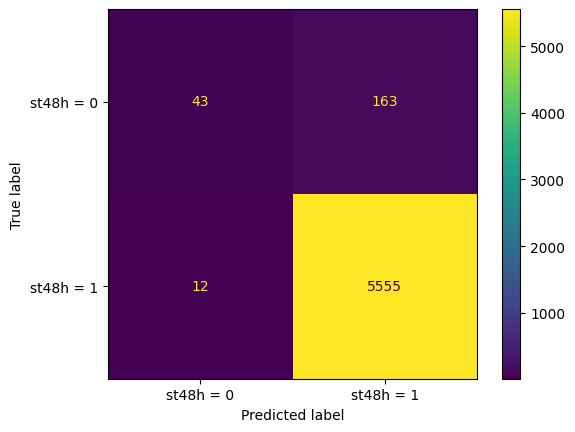

In [159]:
y_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['st48h = 0', 'st48h = 1'])
disp.plot()
plt.show()

#### Confusion matrix has a TP at (0,0), FP(0,1), FN(1,0) and TN(1,1)
plot_confusion_matrix is deprecated and replaced by ConfusionMatrixDisplay.
There is still some inconsistency with our model, Lets use scale_pos_weight to help with imbalanced data. Lets use Cross Validation to optimize parameters

#### Optimizing Parameters using Cross Validation and Grid Search()

XGBoost has a lot of parameters, such as max_depth which is maximum tree depth, learning_rate or eta (gamma) the parameter that encourages pruning and reg_lambda the regularization parameter


Since we have too many parameters we will use GridSearchCV(). It will test all the parameters that we tell it to

### Building, Evaluating, Drawing and Interpreting the Optimized XGBoost Model

In [160]:
clf_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    seed=42,
    gamma=0.25,
    learning_rate=0.1,  # Correct parameter
    max_depth=4,
    reg_lambda=10,
    scale_pos_weight=3,
    subsample=0.9,
    colsample_bytree=0.5,
    n_estimators=100  # Use more estimators for meaningful training
)

# Train the model with early stopping
clf_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # Specify evaluation set
    verbose=True
)


[0]	validation_0-logloss:0.19308
[1]	validation_0-logloss:0.18475
[2]	validation_0-logloss:0.17748
[3]	validation_0-logloss:0.17119
[4]	validation_0-logloss:0.16593
[5]	validation_0-logloss:0.16084
[6]	validation_0-logloss:0.15657
[7]	validation_0-logloss:0.15285
[8]	validation_0-logloss:0.14943
[9]	validation_0-logloss:0.14690
[10]	validation_0-logloss:0.14486
[11]	validation_0-logloss:0.14259
[12]	validation_0-logloss:0.14059
[13]	validation_0-logloss:0.13909
[14]	validation_0-logloss:0.13792
[15]	validation_0-logloss:0.13693
[16]	validation_0-logloss:0.13566
[17]	validation_0-logloss:0.13512
[18]	validation_0-logloss:0.13428
[19]	validation_0-logloss:0.13409
[20]	validation_0-logloss:0.13361
[21]	validation_0-logloss:0.13290
[22]	validation_0-logloss:0.13293
[23]	validation_0-logloss:0.13236
[24]	validation_0-logloss:0.13210
[25]	validation_0-logloss:0.13178
[26]	validation_0-logloss:0.13162
[27]	validation_0-logloss:0.13118
[28]	validation_0-logloss:0.13106
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

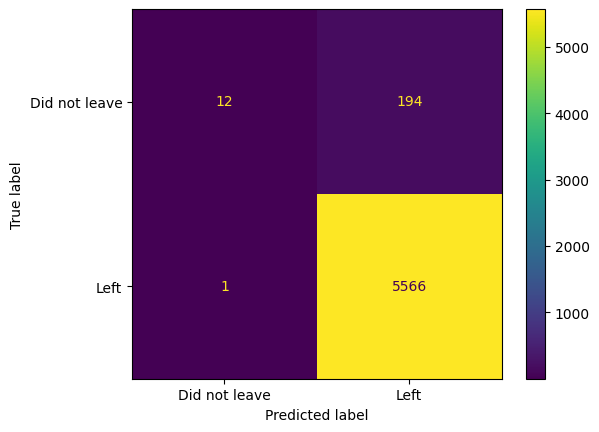

In [161]:
y_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did not leave', 'Left'])
disp.plot()
plt.savefig('confusion_matrix.png')
plt.show()


##### Drawing an XGBoost Tree

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:47:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "learn_rate" } are not used.

  warnings.warn(smsg, UserWarning)


weight:  {'renal': 2.0, 'avg_body_temperature': 1.0, 'albumin': 1.0, 'aniongap': 3.0, 'avg_chloride_chem': 1.0, 'avg_baseexcess': 3.0, 'icu_hours_33': 1.0, 'icu_hours_41': 1.0}
gain:  {'renal': 9.053125381469727, 'avg_body_temperature': 2.43115234375, 'albumin': 31.319446563720703, 'aniongap': 35.591800689697266, 'avg_chloride_chem': 5.70466423034668, 'avg_baseexcess': 2.687140703201294, 'icu_hours_33': 9.486602783203125, 'icu_hours_41': 9.44708251953125}
cover:  {'renal': 41.39352798461914, 'avg_body_temperature': 4345.55810546875, 'albumin': 82.78705596923828, 'aniongap': 3286.35546875, 'avg_chloride_chem': 54.13837814331055, 'avg_baseexcess': 1454.25634765625, 'icu_hours_33': 538.4426879882812, 'icu_hours_41': 536.8087158203125}
total_gain:  {'renal': 18.106250762939453, 'avg_body_temperature': 2.43115234375, 'albumin': 31.319446563720703, 'aniongap': 106.77540588378906, 'avg_chloride_chem': 5.70466423034668, 'avg_baseexcess': 8.061422348022461, 'icu_hours_33': 9.486602783203125, 'i

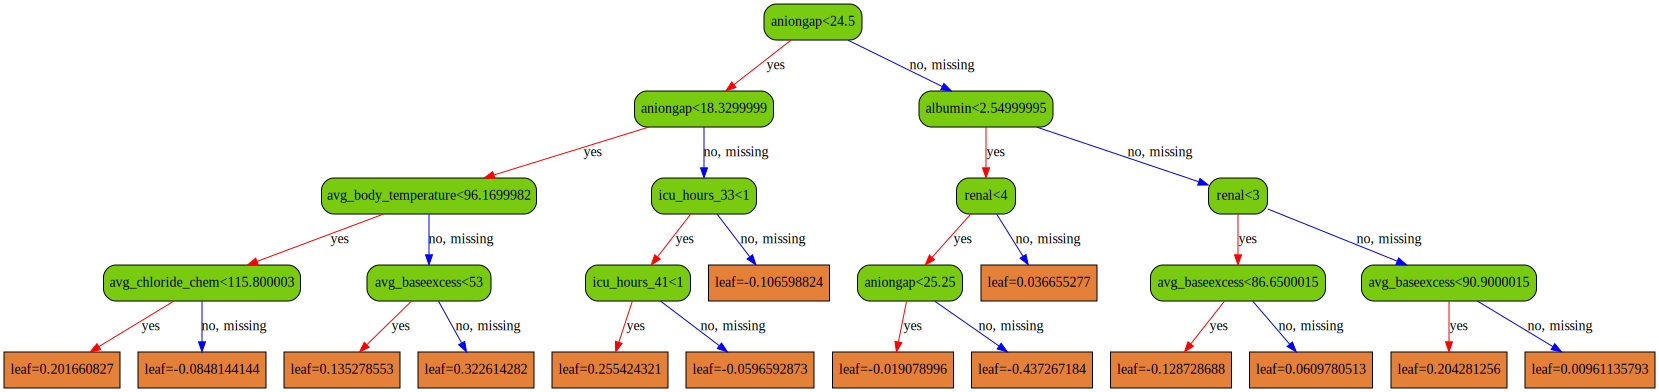

In [162]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
seed=42,
gamma=0.25,
learn_rate=0.1,
max_depth=4,
reg_lambda=10,
scale_pos_weight=3,
subsample=0.9,
colsample_bytree=0.5,
n_estimators=1)
clf_xgb.fit(X_train, y_train)

# weight is the number of times a feature is used to split the data across all trees.(no. of times a features is used in a branch or root across all trees)
# gain is the average gain across all splits the feature is used in.
# cover is the average coverage across all splits the feature is used in.
# total_gain is the total gain across all splits the feature is used in.
# total_cover is the total coverage across all splits the feature is used in.

bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box', 'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)
